#### 작업스케줄링 환경에서 모델을 학습시켜보는 코드입니다.
#### 자세한 사항은 docs/customEnv.md와 scheduler_env/customEnv.py를 참고해주세요

In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg
from stable_baselines3.common.env_checker import check_env

from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

In [2]:
from scheduler_env.customEnv import SchedulingEnv

In [3]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

Resource x 8 , Order x 12 환경입니다
다른 환경에서 실험을 진행하고 싶다면 orders, resources 디렉토리를 참고해주세요

혹시 아래에서 오류가 발생할 경우 실행을 한 번 더 눌러주세요

In [4]:
env = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-deadline.json")
check_env(env)

아래는 랜덤으로 스케줄링을 진행한 것 입니다.
각 지표의 의미는 customEnv.py 파일을 참고해주세요

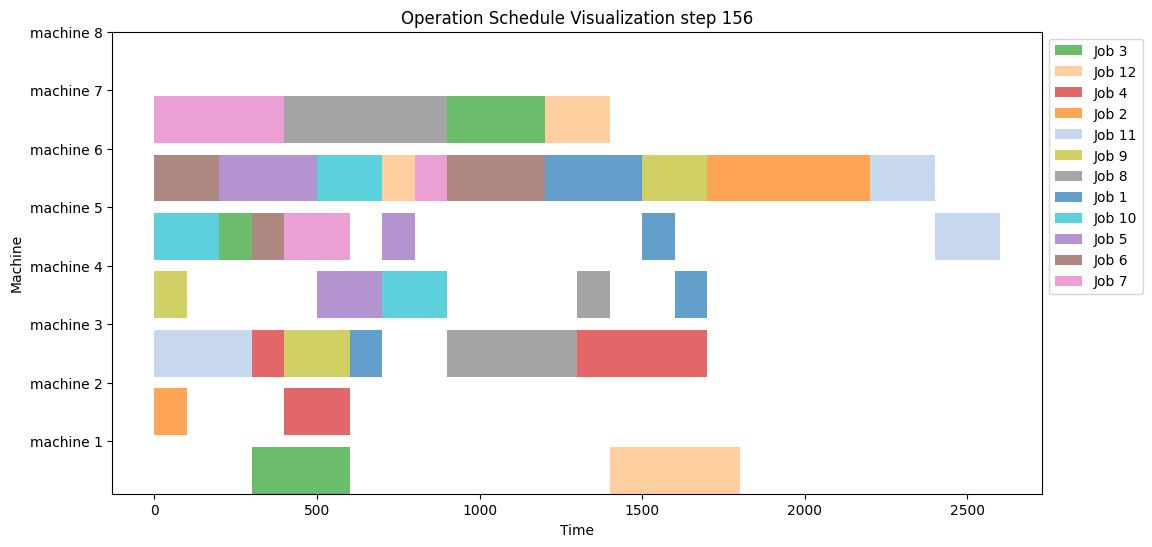

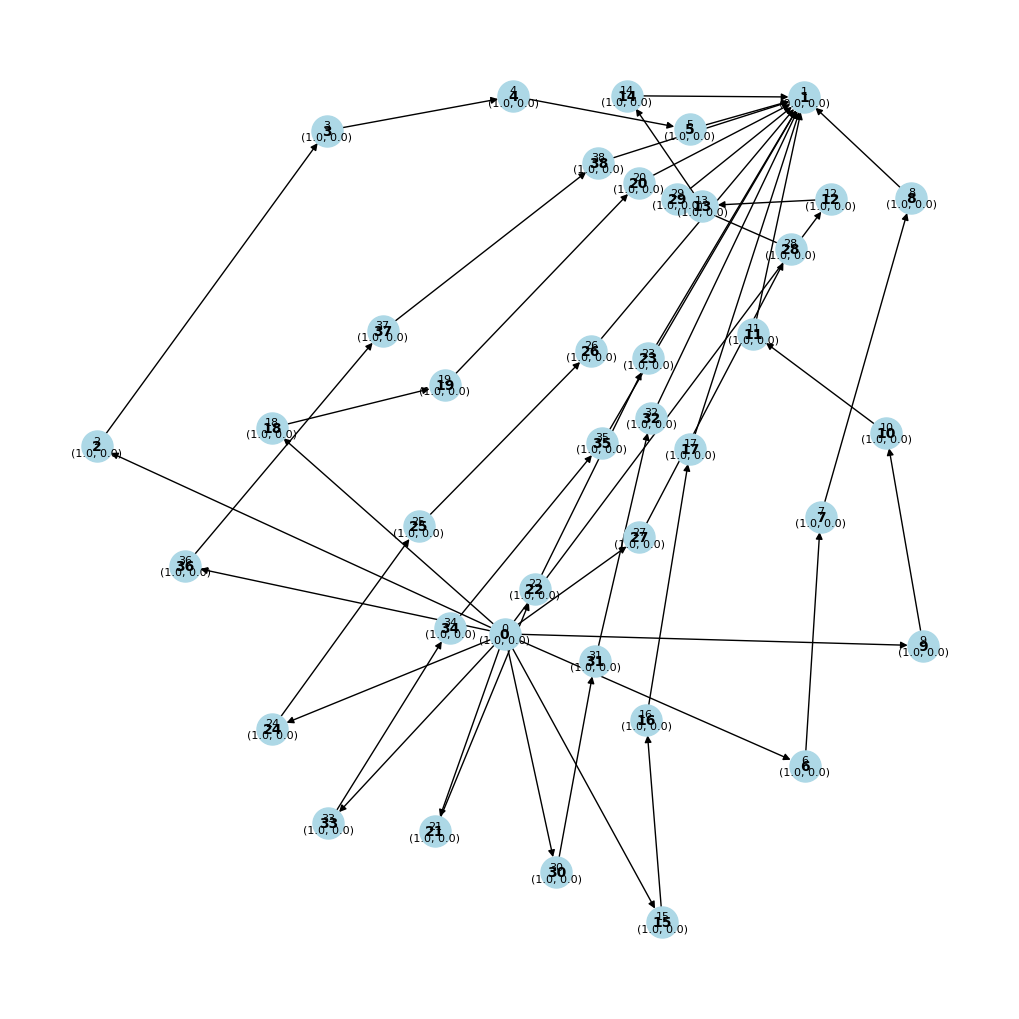

In [7]:
step = 0
obs, info = env.reset()
while True:
    step += 1
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    done = terminated or truncated
    
    if done:
        # print("Goal reached!", "final score=", reward)
        # print('finish_time', info['finish_time'])
        # print('order_density', info['order_density'])
        # print('resource_operation_rate', info['resource_operation_rate'])
        # print('order_deadline', info['order_deadline'])
        # print('order_time_exceeded', info['order_time_exceeded'])
        env.render()
        break

env.visualize_graph()

In [12]:
env2 = SchedulingEnv(machine_config_path= "instances/Machines/v0-2.json", job_config_path = "instances/Jobs/v0-3x3-deadline.json", weight_final_time=20, weight_job_deadline=80, weight_op_rate=0, target_time = 1500)
check_env(env2)

Goal reached! final score= 14.666666666666668
finish_time 1900
job_density [0.6, 1.0, 0.15789473684210525, 0.375, 1.0, 0.16666666666666666, 0.3333333333333333, 1.0, 0.5]
machine_operation_rate [0.42105263157894735, 1.0]
job_deadline [450, 500, 400, 800, 1100, 600, 1500, 1500, 900]
job_time_exceeded [250, 900, 1500, 700, 0, 1200, 0, 0, 900]


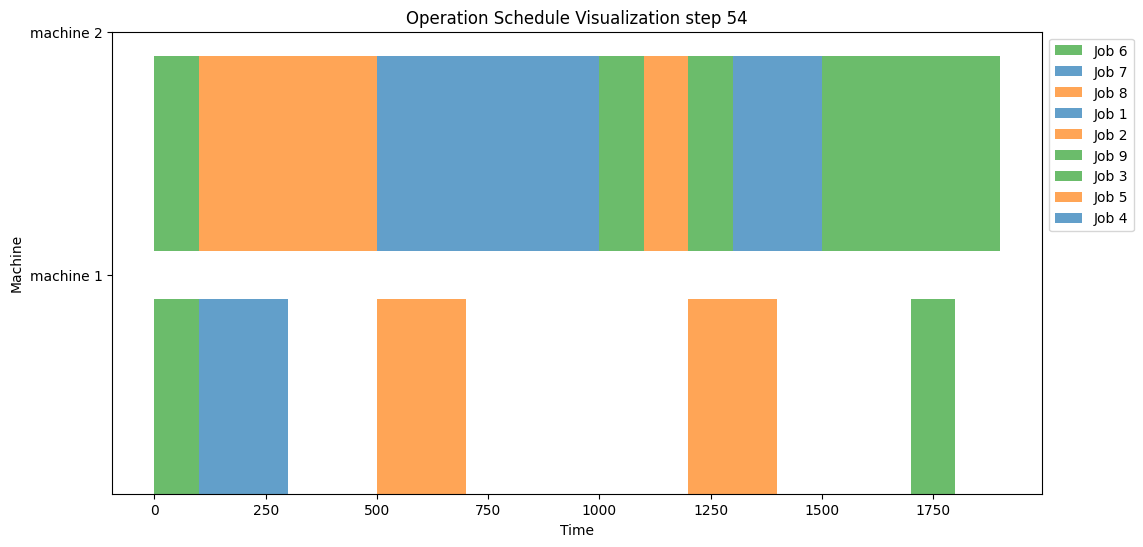

In [13]:
step = 0
obs, info = env2.reset()

while True:
    step += 1
    action = env2.action_space.sample()
    obs, reward, terminated, truncated, info = env2.step(action)
    done = terminated or truncated
    if done:
        print("Goal reached!", "final score=", reward)
        print('finish_time', info['finish_time'])
        print('job_density', info['job_density'])
        print('machine_operation_rate', info['machine_operation_rate'])
        print('job_deadline', info['job_deadline'])
        print('job_time_exceeded', info['job_time_exceeded'])
        env2.render()
        break

PPO 모델을 해당 환경에서 1,000,000 step 만큼 학습시킵니다

In [6]:
model = PPO('MultiInputPolicy', env, verbose=1).learn(50000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.2     |
|    ep_rew_mean     | 84.7     |
| time/              |          |
|    fps             | 3181     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 13.9       |
|    ep_rew_mean          | 87.1       |
| time/                   |            |
|    fps                  | 2234       |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01835743 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.78

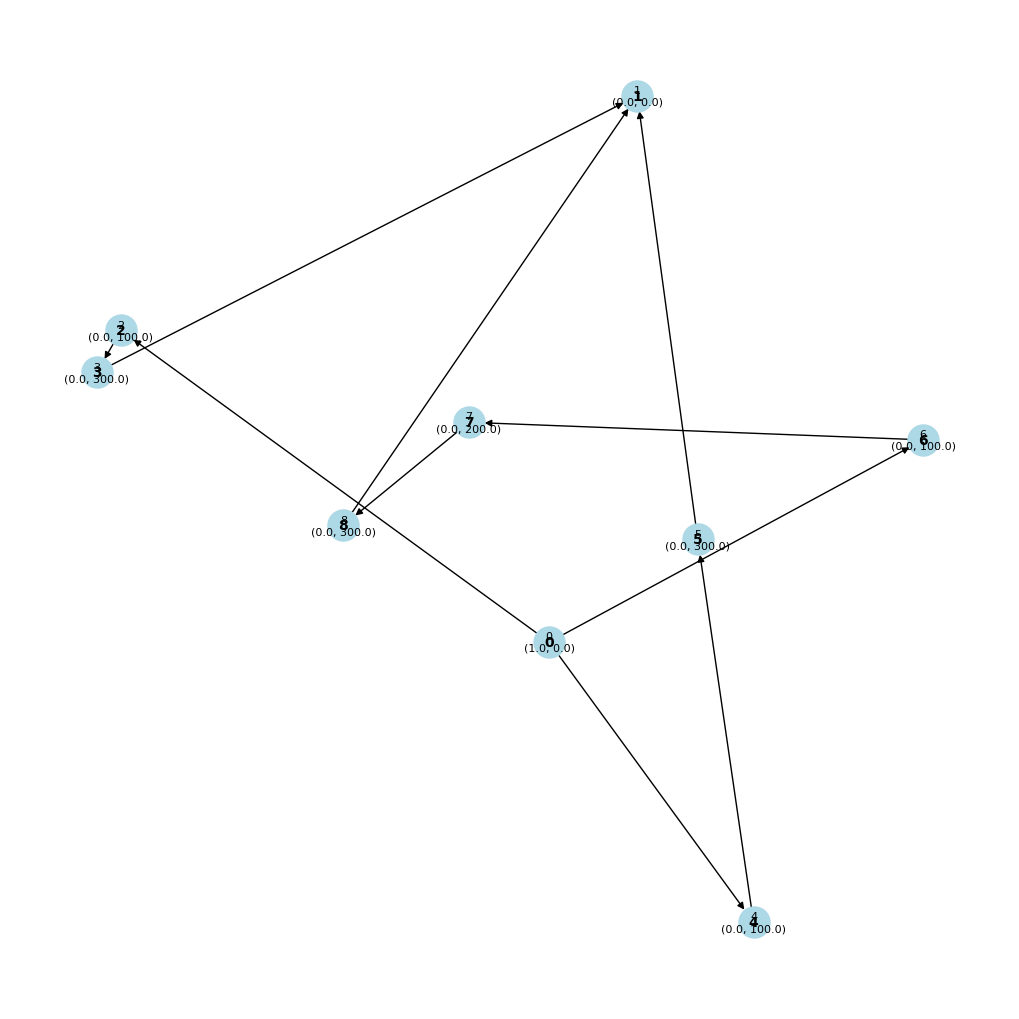

action : 0, 2


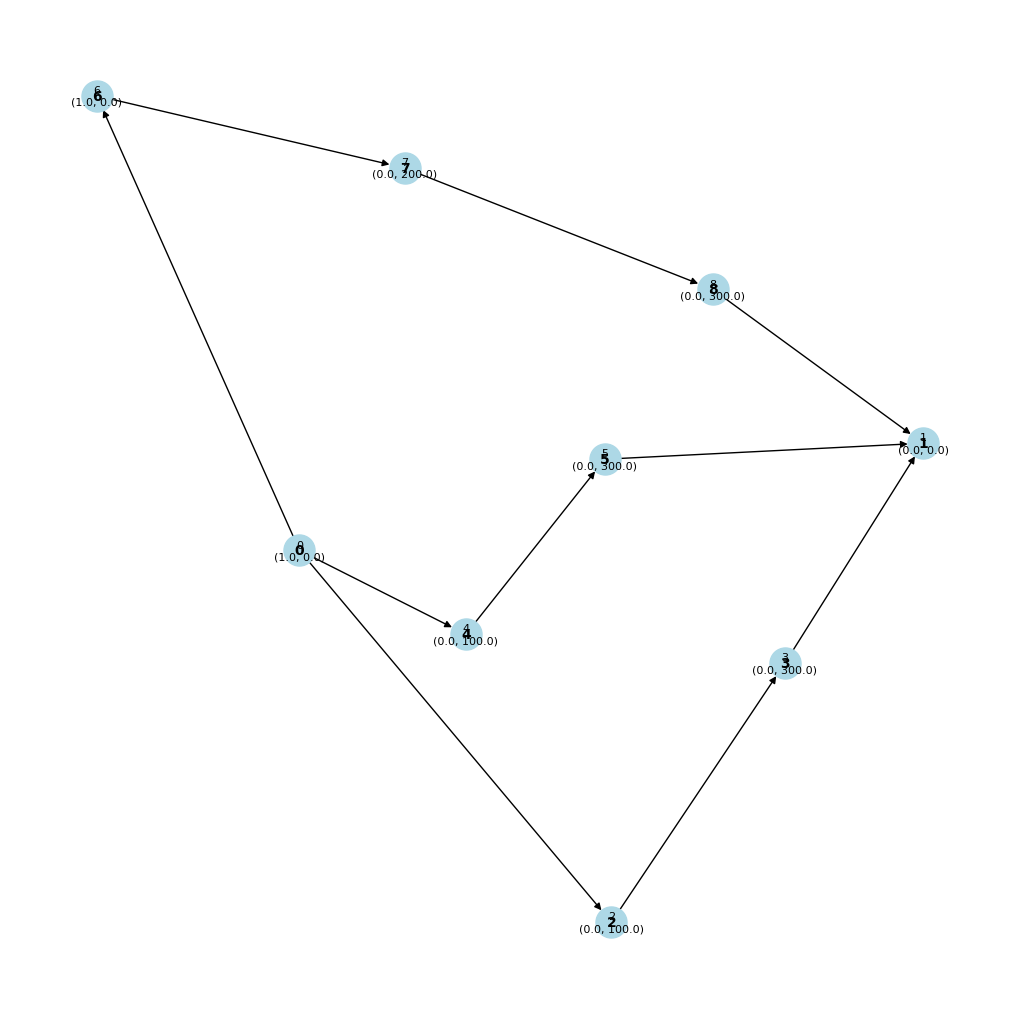

action : 1, 1


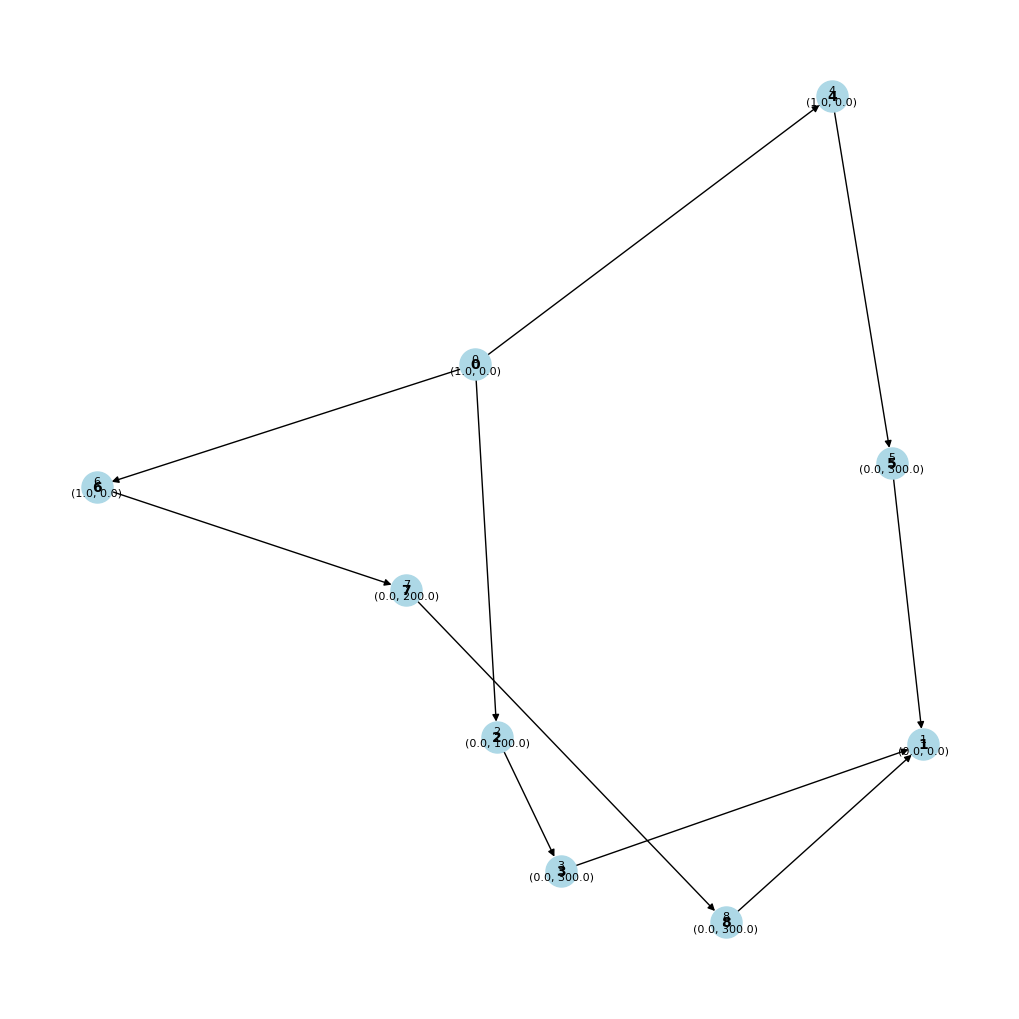

action : 0, 0


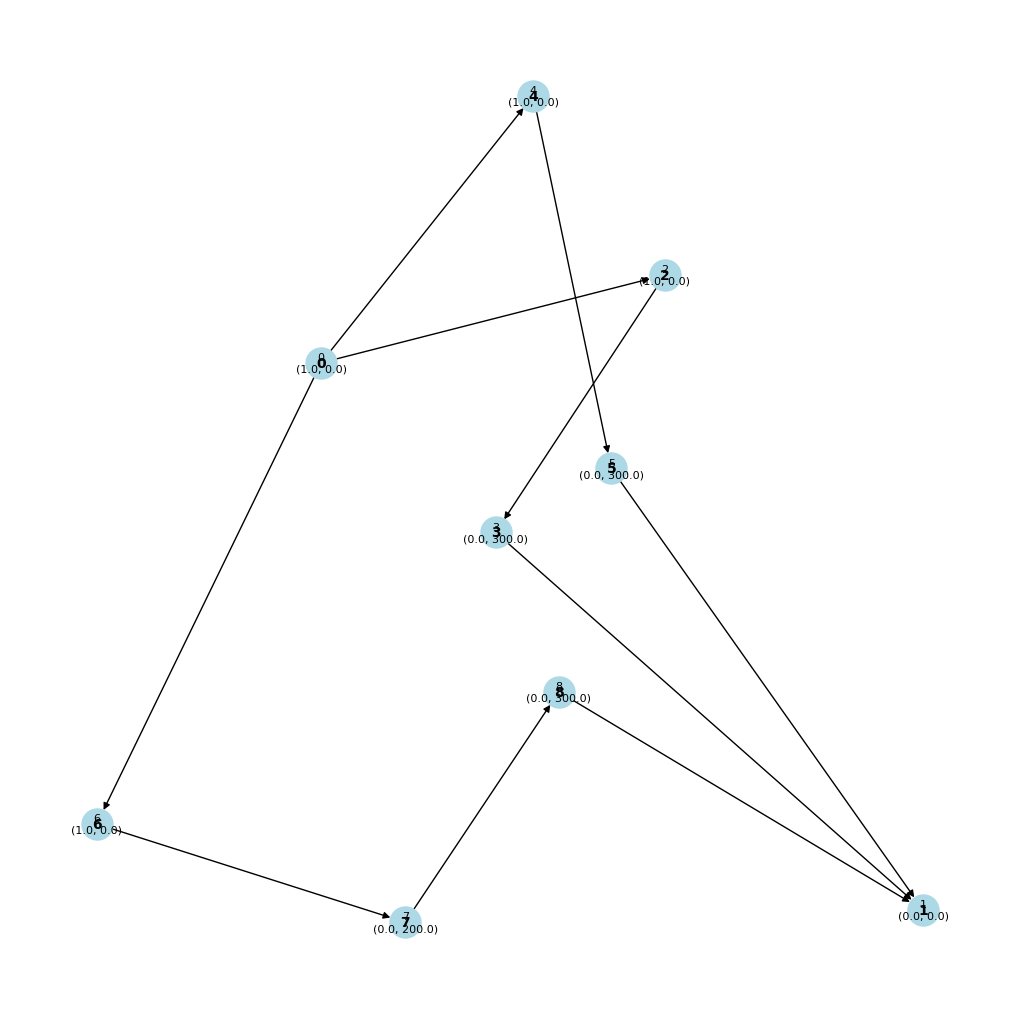

action : 1, 2


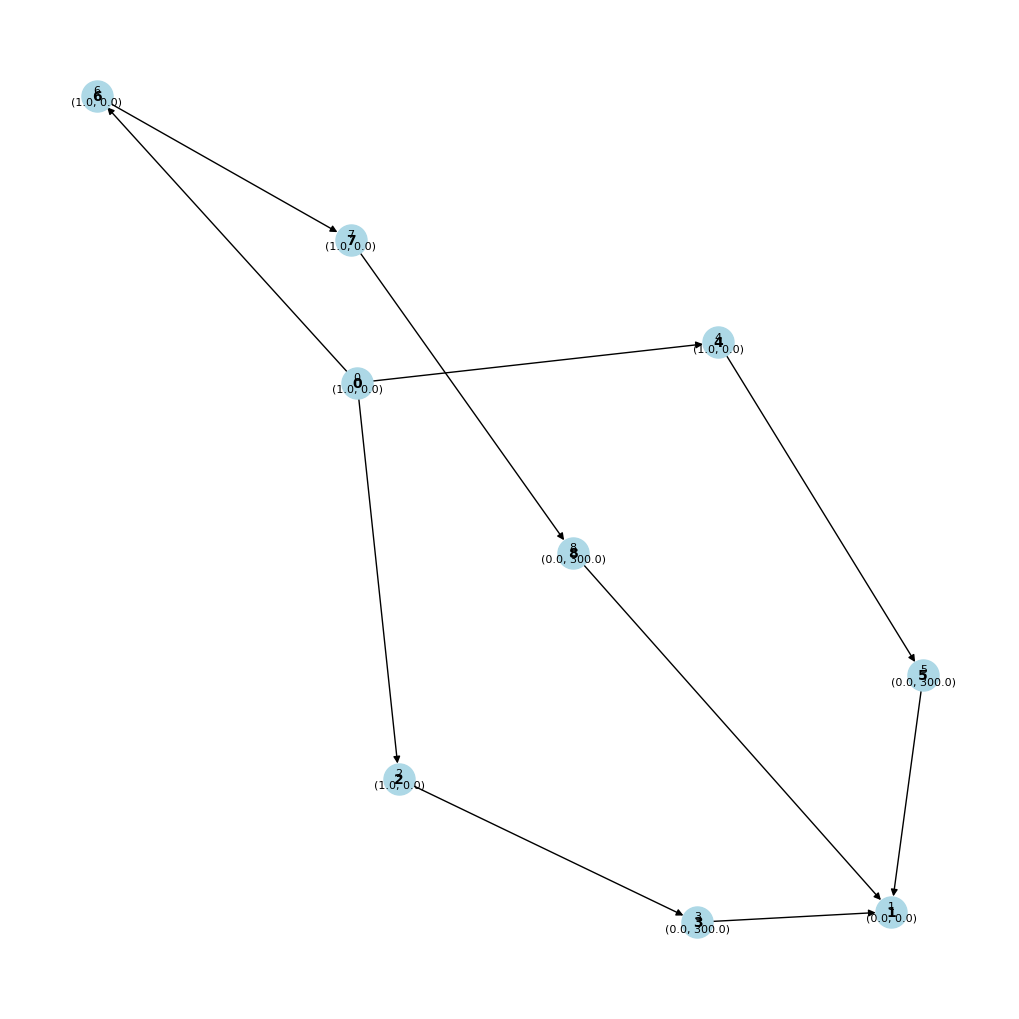

action : 0, 2


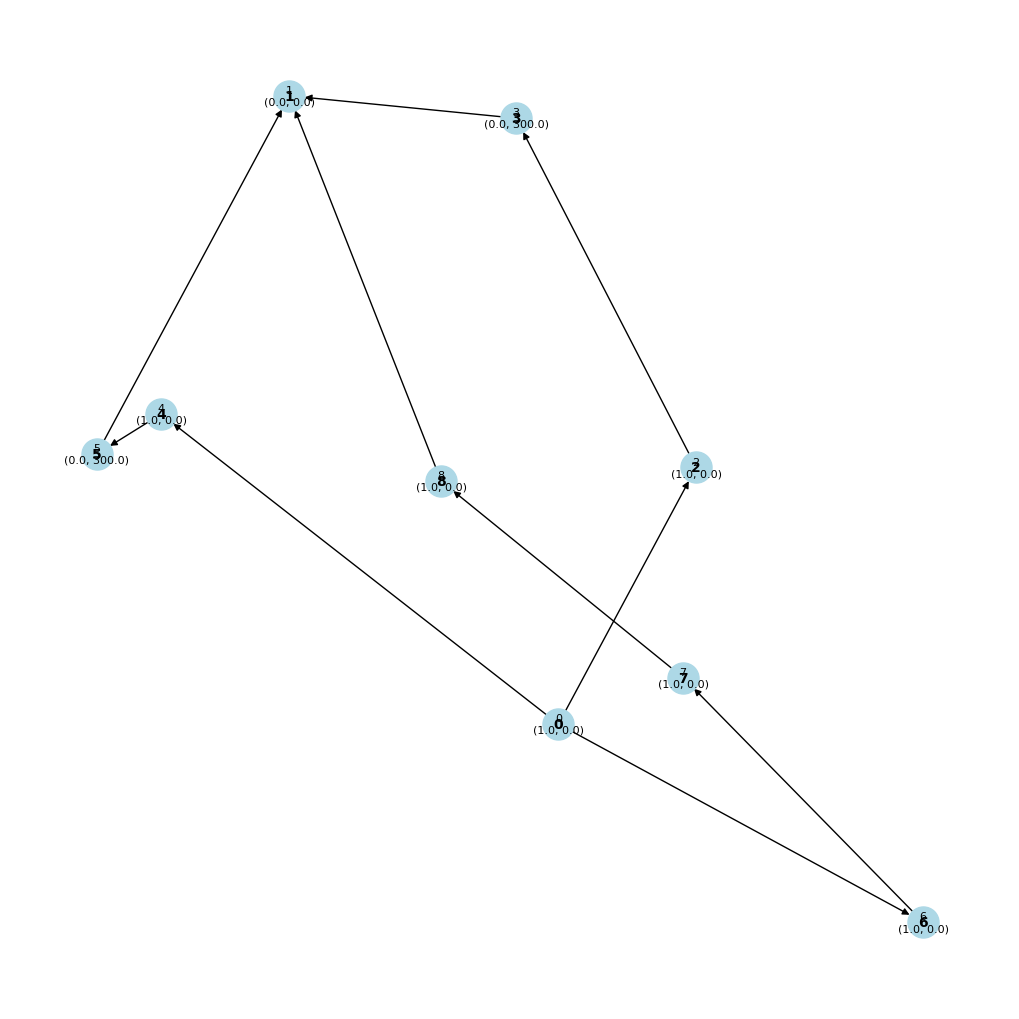

action : 1, 0


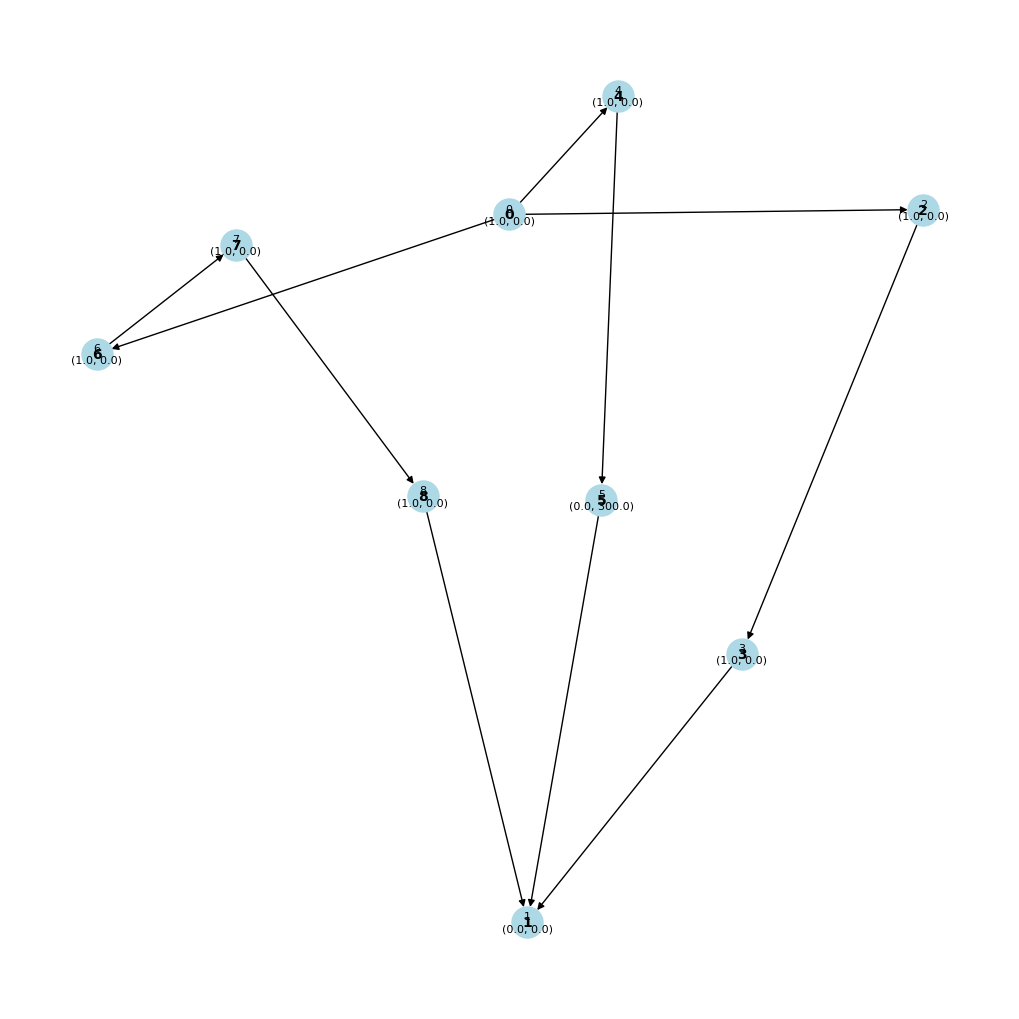

action : 0, 1


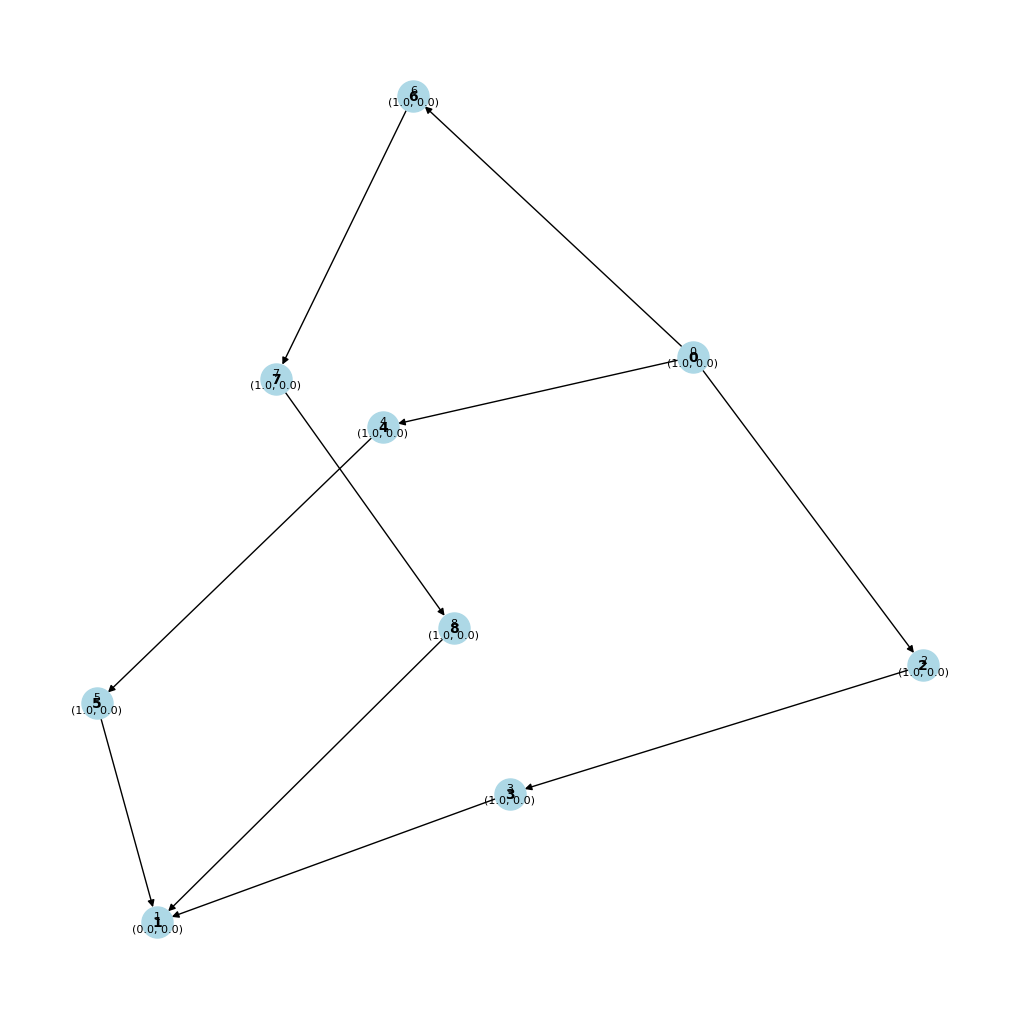

Goal reached! final score= 100.0
finish_time 500
job_density [1.0, 0.6, 1.0]
machine_operation_rate [1.0, 0.8]
job_deadline [450, 500, 400]
job_time_exceeded [0, 0, 0]


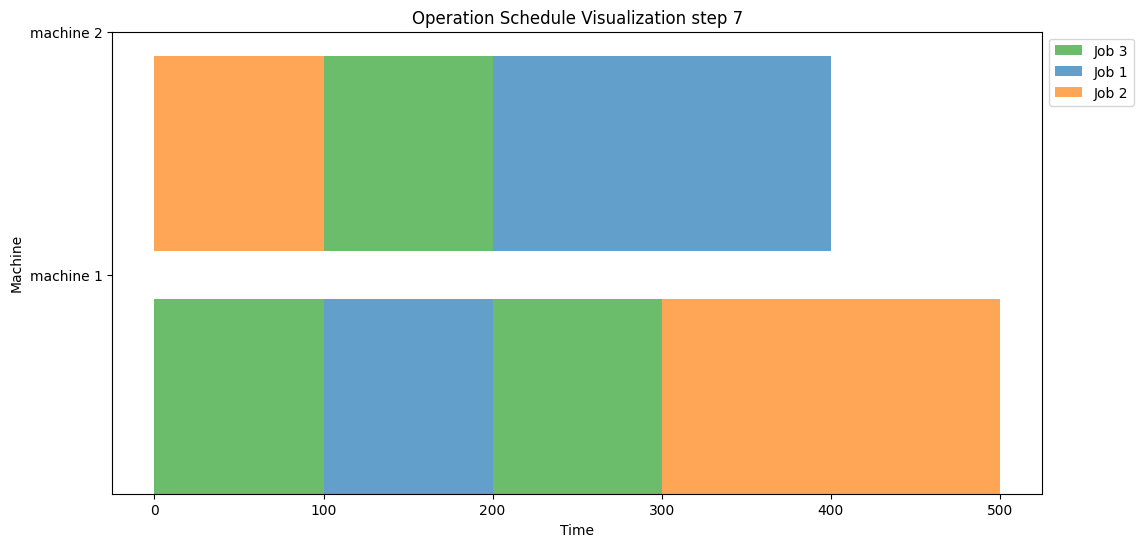

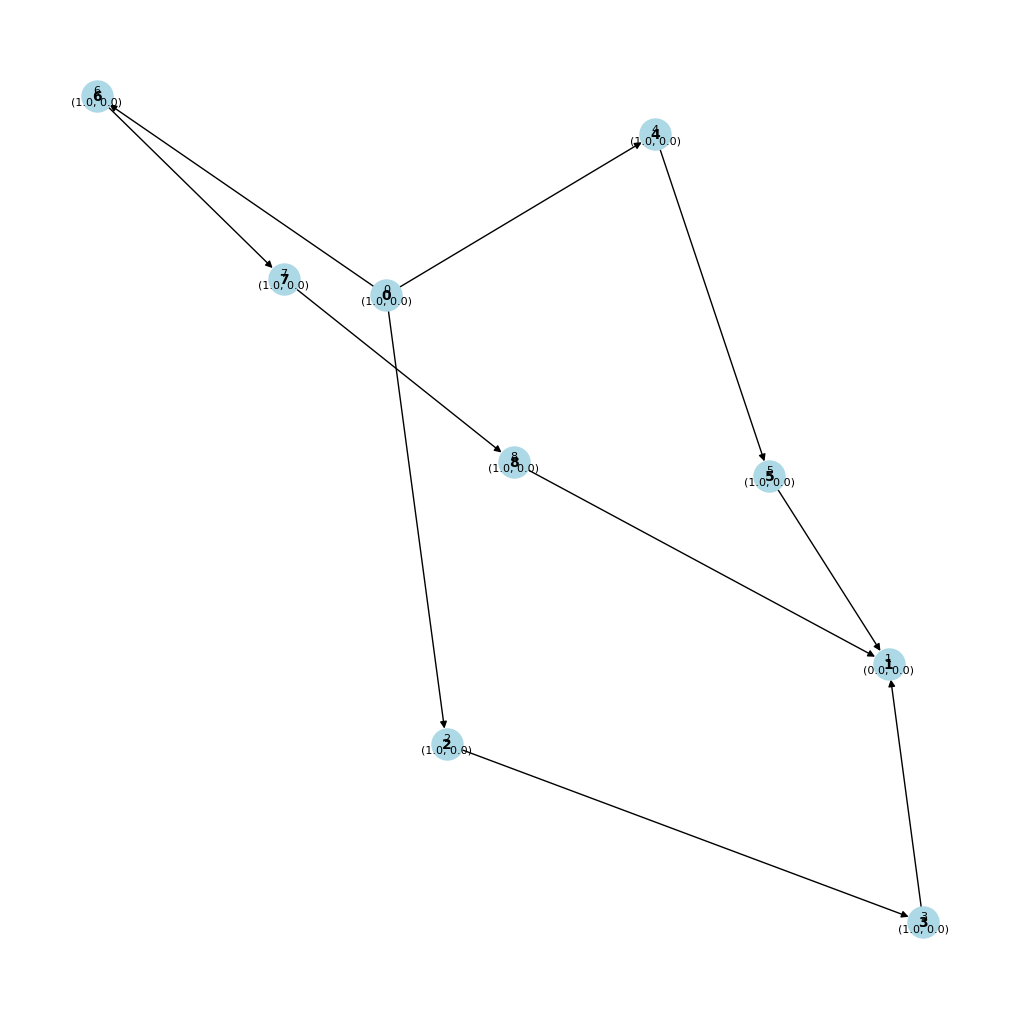

In [7]:
obs, info = env.reset()
done = False
env.visualize_graph()
while True:
    action, _ = model.predict(obs, deterministic = True)
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"action : {action // 3}, {action % 3}")
    env.visualize_graph()
    done = terminated or truncated
    if done:
        print("Goal reached!", "final score=", reward)
        print('finish_time', info['finish_time'])
        print('job_density', info['job_density'])
        print('machine_operation_rate', info['machine_operation_rate'])
        print('job_deadline', info['job_deadline'])
        print('job_time_exceeded', info['job_time_exceeded'])
        env.render()
        break
env.visualize_graph()

In [10]:
model.save("PPO_1,000,000_v2")